# Summary {-}

In the report, we try to identify distinct biological “subtypes”  of patients with liver cancer.Patients are separated into three groups based on their geno type. Survival probabilities among subgroups are different. Tumor stage is a profounding variable for survival probability and a lower number stage tends to have a higher survival probability.

---

# Introduction {-}

Liver cancer is the fifth most commonly occurring cancer in men and the ninth most commonly occurring cancer in women. There were over 840,000 new cases in 2018. Cancer appears when DNA mutates and the translated RNA changes. The corresponding expressed protein also changes because of the RNA. Knowing distinct biology subtypes is very important for providing different treatments to patients. 


---


# Data summary and manipulation {-}
Data used in this report is from [National Cancer Center Genomic Data Commons](https://portal.gdc.cancer.gov/repository?facetTab=files&searchTableTab=files). Patients in our data have liver and intrahepatic bile ducts cancer and their FPKM(Fragments per Kilobase Million), age, sex, etc are included in the data. Informations of each patient are merged into one dataset for the analysis.

Characteristics of the final dataset:

 - Contains information about patients having liver and intrahepatic bile ducts cancer

 - 424 data points are included

 - FPKM(Fragments per Kilobase Million): A measure of the amount of RNA fragments detectedfor a specific gene, adjusted for sequencing depth and gene length

 - Important columns: age, sex, days_to_death, days_to_follow_up, etc
 
 
---

# Method {-}

 - Elbow method is a heuristic method of interpretation and validation of consistency within cluster analysis designed to help find the appropriate number of clusters in a dataset. 
 - WCSS score is a measure of the input data on the k-means objective function i.e. some form of intra-cluster distance relative to inner-cluster distance.
 - T-distributed Stochastic Neighbor Embedding (t-SNE): It is a nonlinear dimensionality reduction technique well-suited for embedding high-dimensional data for visualization in a low-dimensional space of two or three dimensions. Specifically, it models each high-dimensional object by a two- or three-dimensional point in such a way that similar objects are modeled by nearby points and dissimilar objects are modeled by distant points with high probability.
 
 




In [1]:
import numpy as np
import seaborn as sns
import matplotlib.patheffects as PathEffects
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import glob
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
%load_ext rpy2.ipython
import warnings
warnings.filterwarnings('ignore')

In [3]:
# get list of file names
genefilenames = glob.glob('gdc_download_20200204_034949.174766/**/*.gz', recursive = True)
generna = genefilenames[0]
genedat = pd.read_csv(generna,sep = '\t', header = None, names = ['gene', 'rna'] )

# transform rna values 

genedat['logrna'] = genedat['rna'].transform(lambda x: np.log(x+1))


In [4]:
# Look up the link for the gene expression file through the File Name
df_links = pd.read_csv('gdc_sample_sheet.2020-01-30.tsv', sep = '\t')
filename = generna.split('/')[2] # extract filename from file path
gene_df = genedat.iloc[:,[0,2]].set_index('gene').T
gene_df.insert(0,'File Name',filename)

In [5]:
# combine all patients gene into one dataframe for analysis
for i in range(1, len(genefilenames)):
    generna = genefilenames[i]
    genedat = pd.read_csv(generna,sep = '\t', header = None, names = ['gene', 'rna'] )

    genedat['logrna'] = genedat['rna'].transform(lambda x: np.log(x+1))
    
    filename = generna.split('/')[2] # extract filename from file path
    temp = genedat.iloc[:,[0,2]].set_index('gene').T
    temp.insert(0,'File Name',filename)
    gene_df = gene_df.append(temp, ignore_index=True)
df_links = gene_df.merge(df_links, left_on = 'File Name', right_on = 'File Name', how = 'left')

In [6]:
# merge information of patients to clean dataset
clinical = pd.read_csv('clinical.tsv', sep = '\t')
clean = df_links.merge(clinical[['submitter_id', 'age_at_index','gender','vital_status', 
   'days_to_death', 'days_to_last_follow_up', 'tumor_stage', 
   'tumor_grade']].drop_duplicates(), left_on = 'Case ID', right_on = 'submitter_id', how = 'left')

In [7]:
# remove paients that vital_status is not reported and two 'days' are both '--'
clean = clean[(clean['days_to_death'] != '--') | (clean['days_to_last_follow_up'] != '--')]
clean = clean[clean['vital_status'] != 'Not Reported']

In [8]:
clean['os_days'] = np.where(clean['vital_status'] == 'Alive', clean['days_to_last_follow_up'], clean['days_to_death'])
clean['os_days'] = clean['os_days'].astype(int)

In [9]:
# merge stage iiia, iiib, iiic into stage iii, stage iva, ivb into stage iv

list1 = []
for i in range(len(clean)):
    if clean.iloc[i]['tumor_stage'] in {'stage iiia','stage iiib','stage iiic'}:
        list1.append('stage iii')
    elif clean.iloc[i]['tumor_stage'] in {'stage iva','stage ivb'}:
        list1.append('stage iv')
    else:
        list1.append(clean.iloc[i]['tumor_stage'])
clean['stage'] = list1

In [10]:
# Using k-means to divide dataset into five groups

kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(clean.iloc[:,1:60484])
clean['cluster'] = pred_y

---

# Data analysis {-}
## How many subgroups do we derive {-}

From the graph below we can see WCSS against the number of clusters. The dashed line shows the knee point, which is the point of maximum curvature and the change in WCSS begins to level off at this point. Therefore, the number of subgroups we should derive is 5.



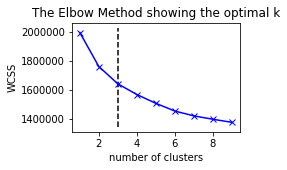

In [11]:
# Implement elbow method to find the best number of cluster

from kneed import KneeLocator
wcss = []
distances = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(clean.iloc[:,1:60484])
    wcss.append(kmeans.inertia_)
kn = KneeLocator(range(1, 10), wcss, S=1.0, curve='convex', direction='decreasing')

plt.figure(figsize=(3, 2))
plt.xlabel('number of clusters')
plt.ylabel('WCSS')
plt.title('The Elbow Method showing the optimal k')
plt.plot(range(1, 10), wcss, 'bx-')
plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.show()

In [12]:
def fashion_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(3, 3))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=10, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

In [13]:
from sklearn.manifold import TSNE
import time
time_start = time.time()

fashion_tsne = TSNE(random_state=1).fit_transform(clean.iloc[:,1:60484])

#print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

## Visualization of groups using t-SNE {-}

From the graph below we can see the visualization of separating subgroups. Each color corresponds to a cluster and similar objects are modeled by nearby points. The nearby points in the graph are almost separated into one cluster and dissimilar objects separating into one group is uncommon. It means the subgroups we derive is fine.

''

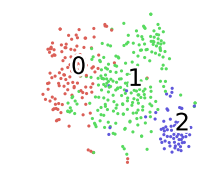

In [14]:
fashion_scatter(fashion_tsne, pred_y)
;

In [15]:
clean.to_csv("clean.csv")

In [16]:
%%R
library("survival")
library(survminer)
clean = read.csv('clean.csv')

R[write to console]: Loading required package: ggplot2

R[write to console]: Loading required package: ggpubr

R[write to console]: Loading required package: magrittr



In [17]:
%%R
clean$dead <- ifelse(clean$vital_status == "Alive", 0,ifelse(clean$vital_status == "Dead", 1, NA))
# use dead as a dummy variable based on vital_status

In [18]:
%%R
km <- survfit(Surv(os_days, dead)~1, data = clean)

## Survival analysis {-}
The graph below is about survival probability against time of different groups. In the first 500 days, survival probability of cluster0 drops sharply and the probability is close to 60%. For cluster1, the survival rate is still higher than 75% in the first 500 days. The overall survival probability of cluster1 is still higher than cluster0 since green line is always higher than red line.

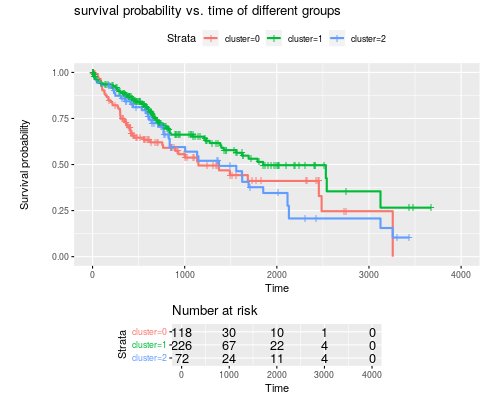

In [19]:
%%R -w 500 -h 400
set.seed(416)
fit <- survfit(Surv(os_days, dead) ~ cluster,data = clean)
ggsurvplot(fit, risk.table = T, title = 'survival probability vs. time of different groups',tables.theme = theme(aspect.ratio=0.2), ggtheme = theme(aspect.ratio=0.5))

## Cox regression {-}

We model the harzard of death at particular time as a linear function of explanatory variables: $x_1$, $x_2$. They are dummy variables for clusters. 

In this case,$$\phi_i = \beta_1x_{1i}+\beta_{2}x_{2i}$$

So, $h_i(t) = exp(\beta_1x_{1i}+\beta_{2}x_{2i})h_0(t)$ or $log(\frac{h_i(t)}{h_0(t)}) = \beta_1x_{1i}+\beta_{2}x_{2i}$

$h_0(t)$ is called the baseline harzard

### Summary table for cox regression {-}

From the summary table below we can see p-value for cluster1 is very significant, which means the hazard of death between cluster0 and cluster1 is significant. The estimated hazard ratio of patients from group 1 vs. patients from group 0 is 0.6129. For cluster2 the effect is not significant since its p-value is 0.61586(exp(-0.4895)) and we can't conclude any difference between cluster2 and cluster0.

In [20]:
%%R
cox.mod <- coxph(Surv(os_days, dead) ~ as.factor(cluster), data = clean)
coef(summary(cox.mod))

                          coef exp(coef)  se(coef)          z    Pr(>|z|)
as.factor(cluster)1 -0.4895013 0.6129320 0.1812988 -2.6999699 0.006934574
as.factor(cluster)2 -0.1065845 0.8988991 0.2124353 -0.5017268 0.615859738


## Tumor Stage effect {-}

I merge stage iiia, stage iiib, stage iiic into stage iii and merge stage iva, stage ivb into stage iv. The plot below tells us a lower number stage tends to have a higher survival probability. For the group not reported and stage iv, because of the lack of data and high death rate, their curves almost drop to zero.

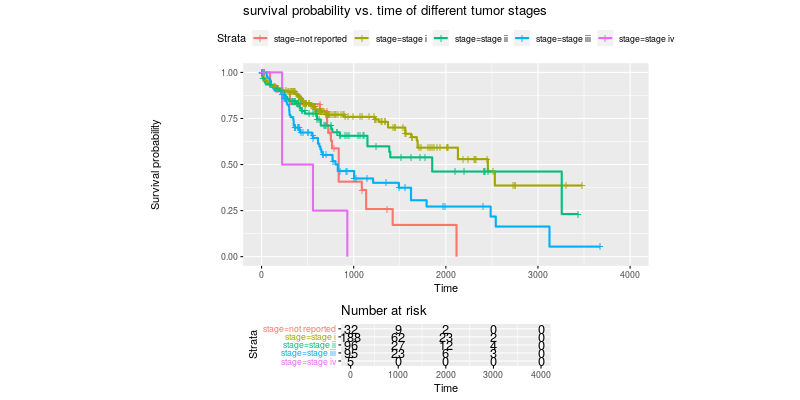

In [21]:
%%R -w 800 -h 400
set.seed(416)
fit <- survfit(Surv(os_days, dead) ~ stage,data = clean)
ggsurvplot(fit, risk.table = T, title = "survival probability vs. time of different tumor stages", tables.theme = theme(aspect.ratio=0.2), ggtheme = theme(aspect.ratio=0.5))


---

# Conclusion {-}

In the report, we try to identify distinct biological “subtypes”  of patients with liver cancer. By using K-means, we separate patients into three groups. Survival probabilities among groups are different and the hazard of death between cluster1 and cluster0 is significant. The hazard ratio is 0.6129. Tumor_stage is a profounding variable for survival probability and a lower number stage tends to have a higher survival probability.


---

# Discussion {-}

Impact of age, tumor stage, and sex between survival rate and subgroup is not shown in this report because the impacts are not significant. Larger datasets that contain more information about patients can solve this problem. 